In [1]:
import sys,os
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import numpy as np
from prep_data import Dataset
import torch
from torch import autograd
from torch.utils.data import DataLoader
from unet import UNet
import torch.nn as  nn
import random
from scipy.ndimage.filters import gaussian_filter1d
from util import  plot_models1D, plot_history, scale_data, plot_models1D2
import time 
import pickle



In [2]:


def r2_score(target, prediction):
    """Calculates the r2 score of the model
    
    Args-
        target- Actual values of the target variable
        prediction- Predicted values, calculated using the model
        
    Returns- 
        r2- r-squared score of the model
    """
    r2 = 1- torch.sum((target-prediction)**2) / torch.sum((target-target.float().mean())**2)
    return r2.cpu().detach()


def run_training(model,opt,criterion,training_data,valid_data,num_epoch=100,batchsz=32):
	ntrain = training_data.x_data.shape[0]
	nvalid = valid_data.y_data.shape[0]
	train_loader= DataLoader (dataset=training_data,batch_size=batchsz,shuffle=True)
	valid_loader= DataLoader(dataset=valid_data,batch_size=batchsz,shuffle=True)

	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,threshold=1e-3,verbose=True)		
	loss_train = []
	loss_valid = []
	R2_train = []
	R2_valid = []
	t_start = time.time()
	# add_noise = GaussianNoise(0.01) # This is a noise layer, used for regularization only for training, changing the standard deviation might change the output
	for epoch in range (num_epoch):
		epoch_train_loss=0
		R2_train_running=0
		# loop over batches
		for batch,data in enumerate (train_loader,0):
			inputs,targets = data
			# inputs = inputs.view(inputs.shape[0],1,inputs.shape[1])
			targets = targets.view(targets.shape[0],1,targets.shape[1])
			# inputs = add_noise(inputs)
			pred = model(inputs)
			loss = criterion(pred,targets) 
			R2_train_running += r2_score(targets,pred)
			epoch_train_loss += loss.item()
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()
		epoch_train_loss = epoch_train_loss/(ntrain/batchsz)
		R2_train_running = R2_train_running/(ntrain/batchsz) 

		with torch.no_grad():
			epoch_valid_loss=0 
			R2_valid_running=0
			for batch,data in enumerate (valid_loader,0):
				inputs,targets = data
				targets = targets.view(targets.shape[0],1,targets.shape[1])
				pred = model(inputs)
				loss = criterion(pred,targets)
				R2_valid_running += r2_score(targets,pred)
				epoch_valid_loss += loss.item()
			epoch_valid_loss = epoch_valid_loss/(nvalid/batchsz)
			R2_valid_running = R2_valid_running/(nvalid/batchsz) 

		scheduler.step(epoch_valid_loss)

		loss_train.append(epoch_train_loss)
		loss_valid.append(epoch_valid_loss)	
		R2_train.append(R2_train_running)
		R2_valid.append(R2_valid_running)
		print(f'''epoch: {epoch+1:3}/{num_epoch:3}  Training_loss: {epoch_train_loss:.5e}  Validation_loss: {epoch_valid_loss:.5e}
		 R2_Training: {R2_train_running:.5}  R2_Validation: {R2_valid_running:.5}''')
	t_end = time.time()
	print("=================================================")
	print(f"Training time is {(t_end-t_start)/60} minutes.")
	print("=================================================")

	return model,np.array(loss_train),np.array(loss_valid),np.array(R2_train),np.array(R2_valid)
	# return model,loss_train,loss_valid,R2_train,R2_valid




## For determinstic behaviour 

## For determinstic behaviour 

In [3]:
torch.backends.cudnn.deterministic = True
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)



## i/o files 

In [4]:
# reading the inputs and targets
# data_file = 'output_ibx_tv_6offset'
data_file = 'output_ibx_lbfgs_6offset_noTV_noSMTH'
path_data = f'../gen_data/{data_file}/'
ifile = 0
endfile= 20000

# Net par
batchsz= 16
LR = 0.0001
num_epoch =  50
chanl = 16
in_channels = 1 # input channel
test_ratio = 0.2 # for splitting the data 
skip= False
# netname = f'unet_flood_{data_file}_lr{LR}_chanl{chanl}_batch{batchsz}'  # train with bp_mean
netname = f'unet_flood_{data_file}_lr{LR}_chanl{chanl}_batch{batchsz}_skip{int(skip)}'
print(f" Net name : {netname}")


# Allocate the arrays 
nm = 0
nt = 201

inp = []
oup = []
init = []
true = []

for k in range(ifile,endfile):
	if os.path.isfile(path_data+'inv_m'+str(k)+'.npy'): 
		inp_tmp = np.load(path_data+'inv_m'+str(k)+'.npy')
		oup_tmp = np.load(path_data+'flood_m'+str(k)+'.npy')
		init_tmp = np.load(path_data+'init_m'+str(k)+'.npy')
		true_tmp = np.load(path_data+'true_m'+str(k)+'.npy')

		inp.append(inp_tmp[-1]) # last inversion iteration 
		oup.append(oup_tmp)
		init.append(init_tmp)
		true.append(true_tmp)

		nm +=1
		if k%1000==0:print('number of models', nm)   

# Convert to arrays 
inp = np.array(inp)[:,:-1] # I remove the last sample just to match the dim for the network
oup = np.array(oup)[:,:-1] # I remove the last sample just to match the dim for the network
init = np.array(init)[:,:-1] # I remove the last sample just to match the dim for the network
true = np.array(true)[:,:-1] # I remove the last sample just to match the dim for the network

print ('loaded shapes for input and output',inp.shape, oup.shape)	

path_output='./output'
if not os.path.exists(path_output):
    os.makedirs(path_output) 
    
path_fig = './output/figure'
if not os.path.exists(path_fig):
    os.makedirs(path_fig) 

path_net = './output/net'
if not os.path.exists(path_net):
    os.makedirs(path_net) 
    

 Net name : unet_flood_output_ibx_lbfgs_6offset_noTV_noSMTH_lr0.0001_chanl16_batch16_skip0
loaded shapes for input and output (6225, 200) (6225, 200)


## Plotting the loaded data 

In [5]:
oup.shape

(6225, 200)

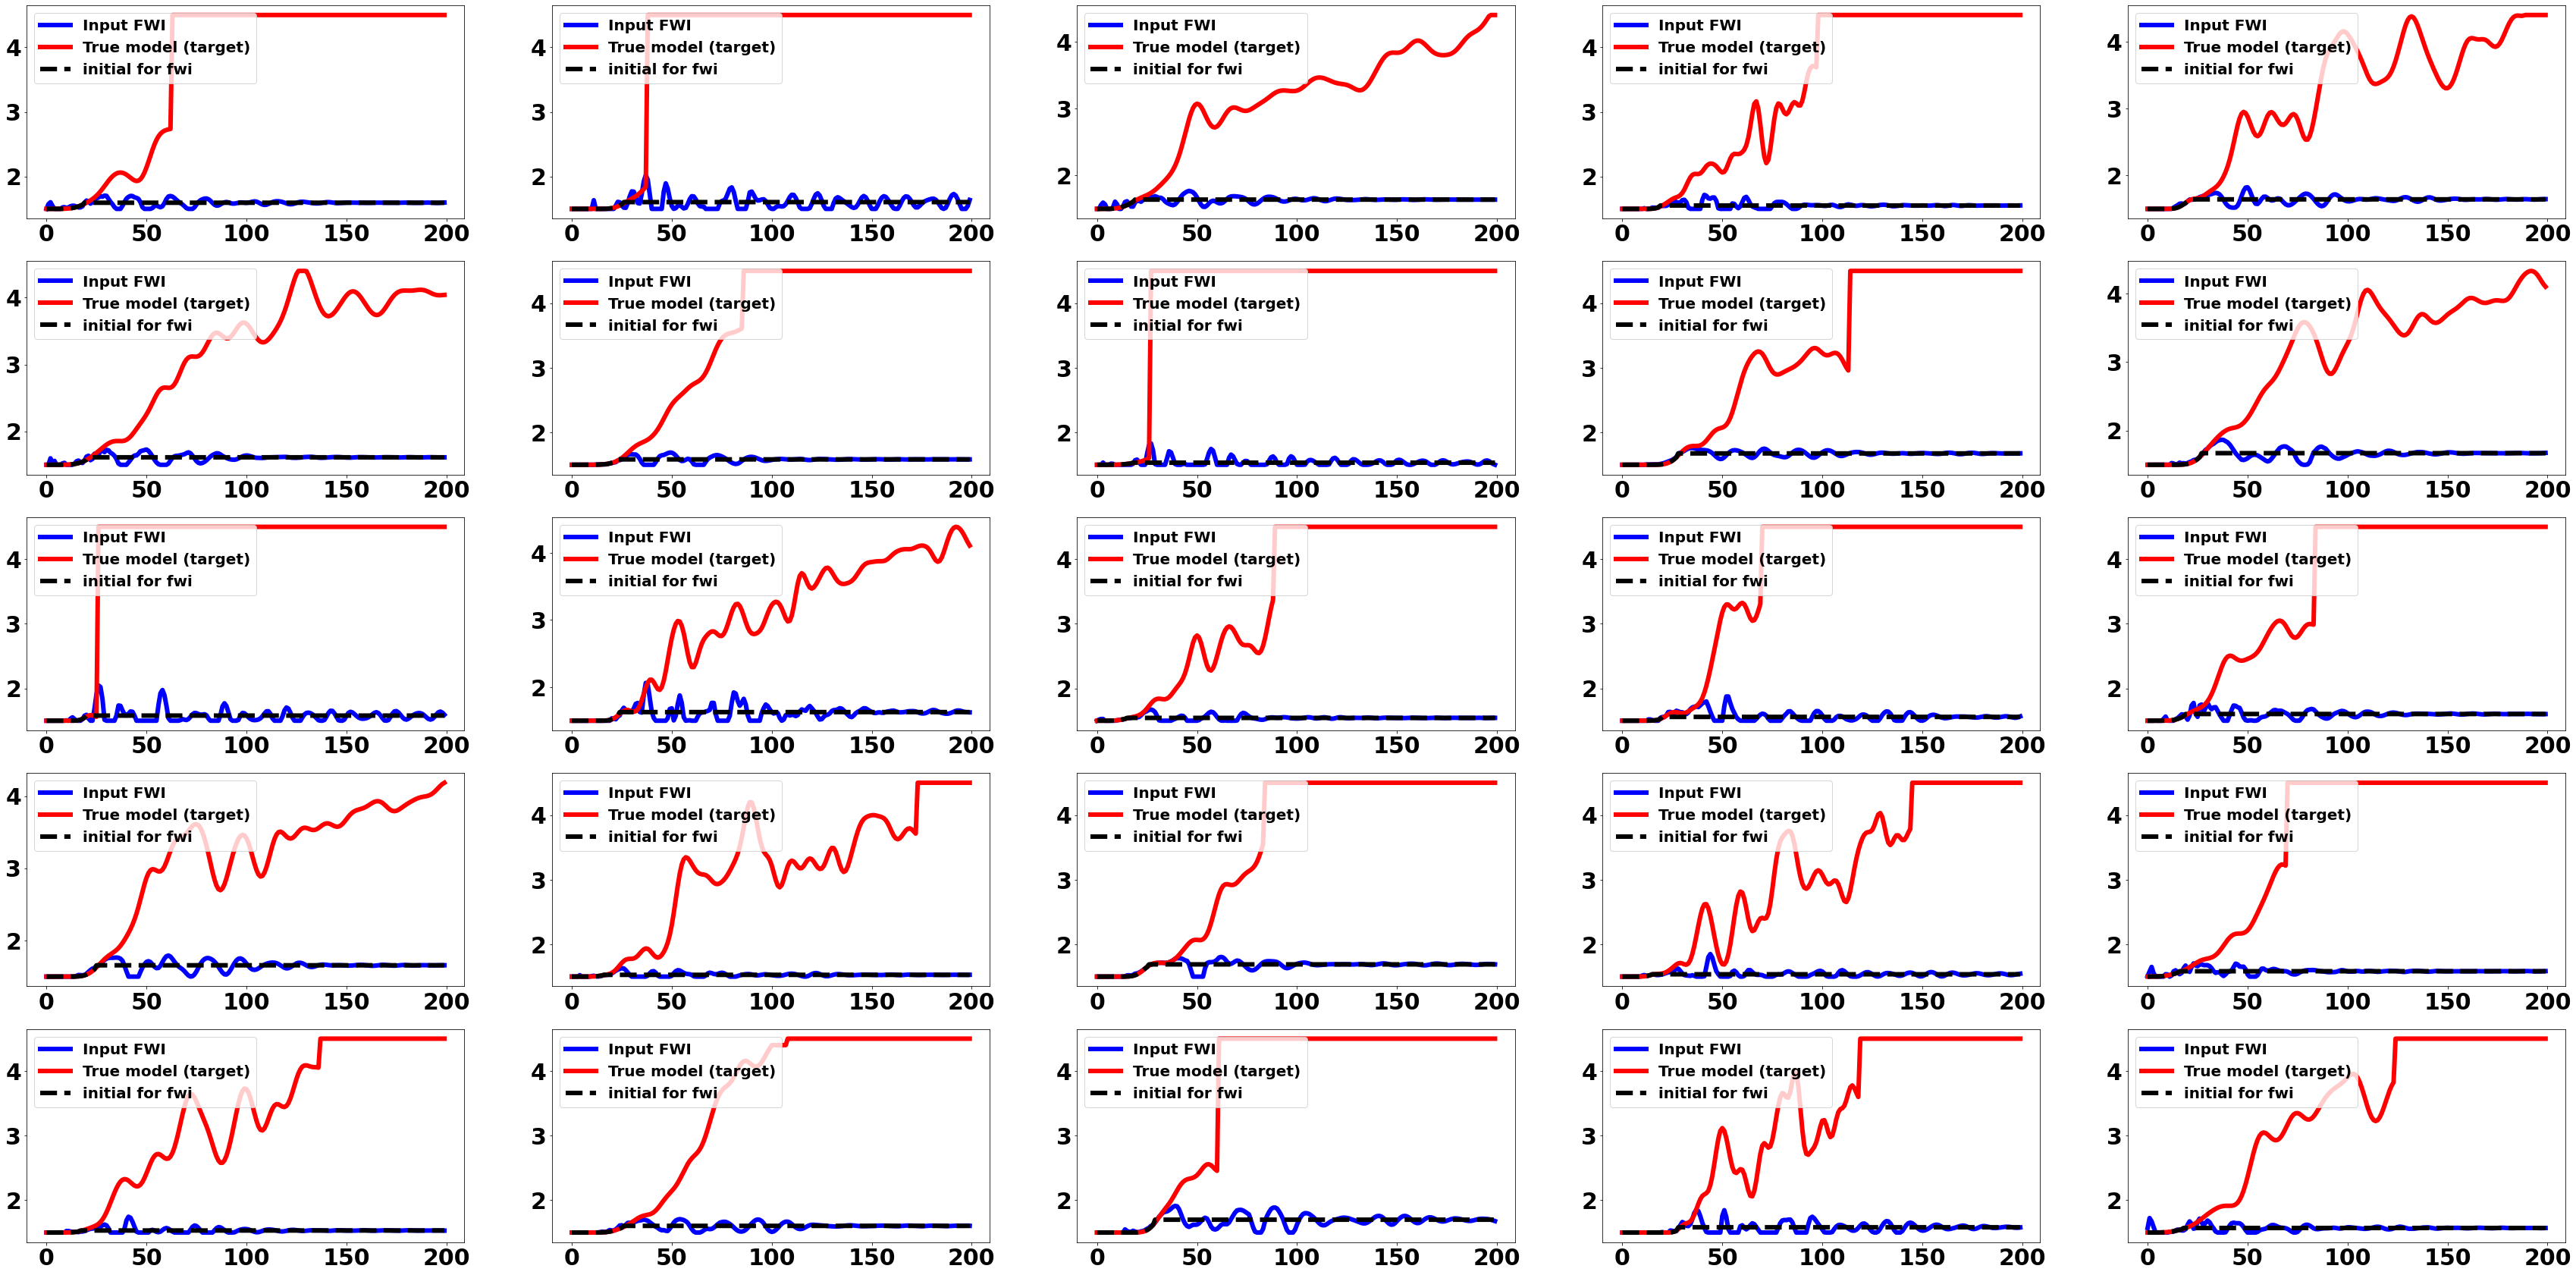

In [7]:
plot_models1D2(inp,oup,init,inp.shape[0],5,5)

## Preparing input and output

In [7]:

# init = init.reshape((init.shape[0],1,init.shape[1]))
inp = inp.reshape((inp.shape[0],1,inp.shape[1]))
# inp = np.concatenate((inp,init),axis=1)


##Normalize the data 
inp = inp/4.5
oup = oup/4.5
init = init/4.5


In [8]:
# print(inp_sc.max())
# print(oup_sc.max())

# plt.plot(inp_sc[0])
# plt.plot(oup_sc[0])



## Split data into training and inference 

In [9]:

# split training and validation
x_train,x_valid, y_train, y_valid,init_train, init_valid, true_train, true_valid = train_test_split(inp,oup,init,true, test_size=test_ratio)
ntrain = x_train.shape[0]
nvalid = x_valid.shape[0]


np.save(f'{path_output}/xtrain_{netname}',x_train)
np.save(f'{path_output}/ytrain_{netname}',y_train)
np.save(f'{path_output}/init_train_{netname}',init_train)
np.save(f'{path_output}/true_train_{netname}',true_train)

np.save(f'{path_output}/xvalid_{netname}',x_valid)
np.save(f'{path_output}/yvalid_{netname}',y_valid)
np.save(f'{path_output}/init_valid_{netname}',init_valid)
np.save(f'{path_output}/true_valid_{netname}',true_valid)



## Scale the data 

In [10]:

# max_inp = x_train.max()
# min_inp = x_train.min()

# max_op = y_train.max()
# min_op = y_train.min()

# min_max = {'min_inp': min_inp,  'max_inp':max_inp, 
#           'min_op': min_op,  'max_op':max_op
# }

# filename = f'scalers/min_max_{netname}.pickle'
# with open(filename,'wb') as f :
#     pickle.dump(min_max,f)

# def scale_min_max(data,min_val,max_val,frange=(-1,1),inv=False):
#     ''' 
#     I generated this custom min max 
#     '''
#     if inv: 
#         x_std = (data - frange[0])/((frange[1] - frange[0] ))  # by solving for below definition 
#         return x_std * (max_val-min_val)  + min_val  
#     else : 
#         x_std =  (data - min_val)/(max_val-min_val)  # Definition from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#         return x_std * (frange[1] - frange[0]) + frange[0]


# # This scale one featrue 
# x_train =  scale_min_max(x_train,min_inp,max_inp)  
# y_train =  scale_min_max(y_train,min_op,max_op)  

# x_valid =  scale_min_max(x_valid,min_inp,max_inp)  
# y_valid =  scale_min_max(y_valid,min_op,max_op)  

In [11]:
x_valid.max()

0.61428773

In [12]:
print('shape of the training data is ', x_train.shape)
print('number of training: ',ntrain )
print('number of validation: ',nvalid )
print('Batch: ',batchsz )

shape of the training data is  (4980, 1, 200)
number of training:  4980
number of validation:  1245
Batch:  16


## Prepare data for pytorch 

In [13]:

training_data=Dataset(x_train,y_train)
valid_data =Dataset(x_valid,y_valid)


## Defining the model 

In [14]:

# define NN model
model = UNet(in_channels=in_channels,out_channels=1,init_features=chanl,skip=skip)

# model = UNet(in_channels=10,out_channels=1,init_features=chanl) # For this use unference 2
model.cuda()
# this should be outer loop
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss() 





## Run training 

In [15]:
# Run trainnig 
model, loss_train, loss_valid, r2_train,r2_valid = run_training(model,optimizer,criterion,training_data,valid_data,num_epoch)




epoch:   1/ 50  Training_loss: 5.76547e-02  Validation_loss: 2.29130e-02
		 R2_Training: 0.088868  R2_Validation: 0.63846
epoch:   2/ 50  Training_loss: 1.62791e-02  Validation_loss: 1.23688e-02
		 R2_Training: 0.745  R2_Validation: 0.80605
epoch:   3/ 50  Training_loss: 1.10831e-02  Validation_loss: 1.02739e-02
		 R2_Training: 0.82693  R2_Validation: 0.83915
epoch:   4/ 50  Training_loss: 9.58986e-03  Validation_loss: 9.66803e-03
		 R2_Training: 0.85052  R2_Validation: 0.8486
epoch:   5/ 50  Training_loss: 8.88670e-03  Validation_loss: 9.54639e-03
		 R2_Training: 0.86162  R2_Validation: 0.85066
epoch:   6/ 50  Training_loss: 8.49154e-03  Validation_loss: 9.64989e-03
		 R2_Training: 0.8679  R2_Validation: 0.84864
epoch:   7/ 50  Training_loss: 8.01277e-03  Validation_loss: 9.28236e-03
		 R2_Training: 0.87534  R2_Validation: 0.85465
epoch:   8/ 50  Training_loss: 7.57488e-03  Validation_loss: 9.60074e-03
		 R2_Training: 0.88225  R2_Validation: 0.84988
epoch:   9/ 50  Training_loss: 7.30

Done training yaaaaaay --------


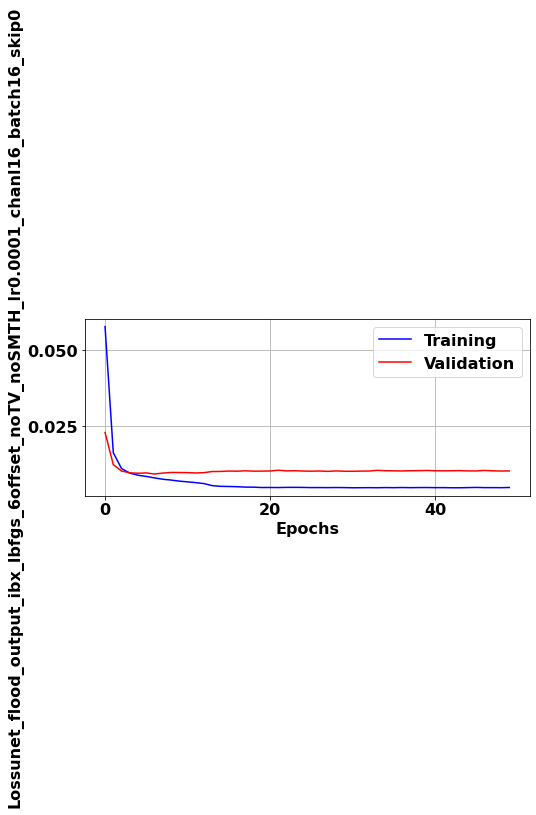

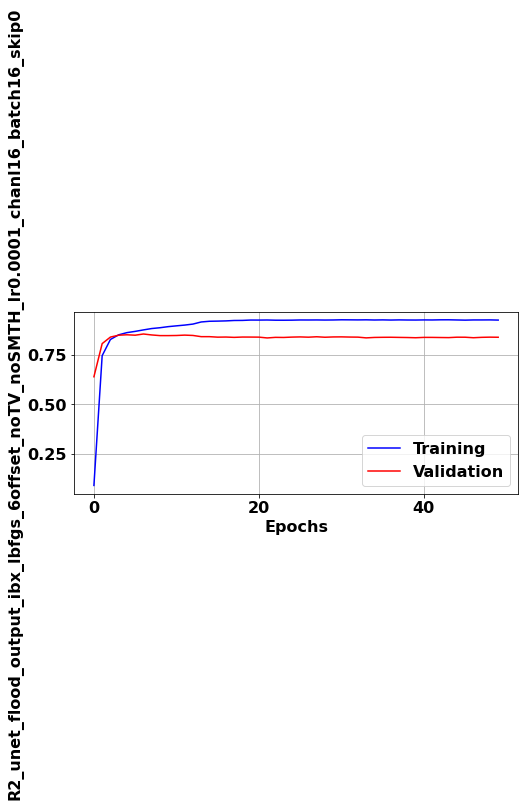

In [16]:
torch.save(model.state_dict(),f'{path_net}/{netname}.pt')
np.save(path_output+'/Training_loss_'+netname,np.array(loss_train))     
np.save(path_output+'/Validation_loss_'+netname,np.array(loss_valid))
np.save(path_output+'/Training_R2_'+netname,np.array(r2_train))
np.save(path_output+'/Validation_R2_'+netname,np.array(r2_valid))

plot_history(loss_train,loss_valid,name='Loss'+netname) 
plot_history(r2_train,r2_valid,name='R2_'+netname)  
print('Done training yaaaaaay --------')

